Most Liveable and Affordable Suburb:
    addressSuburb  addressPostcode  liveability_score  affordability_score  \
14            KEW           3101.0           0.875444             0.857518   
11  HAWTHORN EAST           3123.0           0.894025             0.835535   
29     YARRAVILLE           3013.0           0.862866             0.854236   

    overall_score  
14       0.866481  
11       0.864780  
29       0.858551  


/tmp/ipykernel_2422/1228082123.py:80: UserWarning:

The palette list has more values (6) than needed (3), which may not be intended.



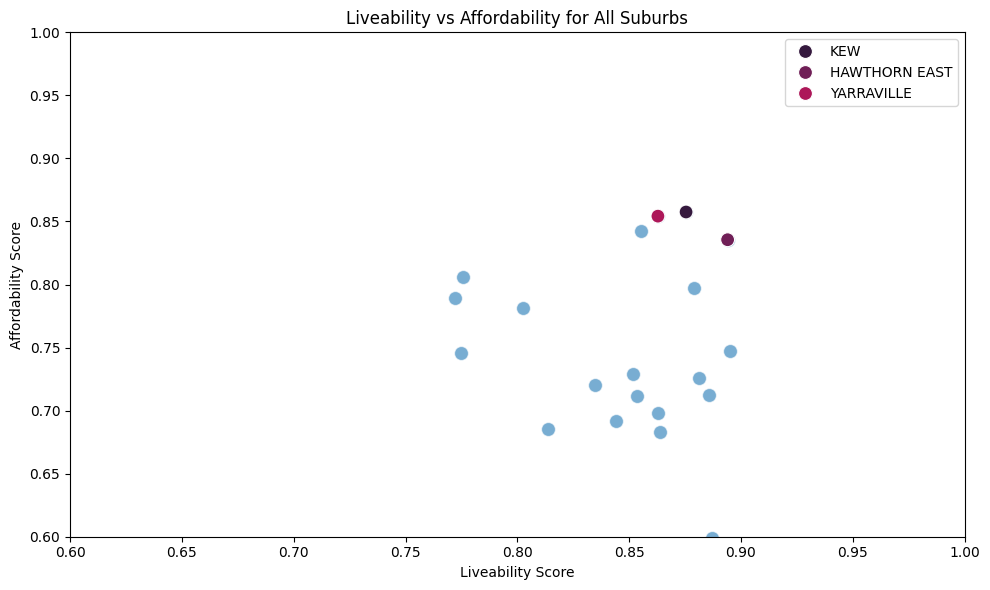

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('../data/curated/combine_all.csv')
df = df.dropna()
# Define metrics for liveability and affordability
liveability_metrics = [
    'IEO_Score',  # Education and occupation opportunities   
    'min_distance_to_shopping_mall',  # Access to amenities
    'min_distance_to_secondary_school',  # Access to education
    'min_distance_to_park',  # Access to green spaces
    'min_walking_distance_to_station', # Access to station
    'medical_institution_count' # Access to medical institution
]

affordability_metrics = [
    'price',    # rental price
    'IER_Score'  # economic resources
]

# Create a copy of the dataframe with only the relevant columns
suburbs_df = df[['addressSuburb', 'addressPostcode'] + liveability_metrics + affordability_metrics].copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the metrics
for column in liveability_metrics + affordability_metrics:
    if column.startswith('min_distance') or column.startswith('min_walking') or column.startswith('medical'):
        # For distance metrics, lower is better, so we invert the scale
        suburbs_df[f'{column}_normalized'] = 1 - scaler.fit_transform(suburbs_df[[column]])
    else:
        suburbs_df[f'{column}_normalized'] = scaler.fit_transform(suburbs_df[[column]])

# Invert the price scale (lower price is better)
suburbs_df['price_normalized'] = 1 - suburbs_df['price_normalized']

# Calculate liveability and affordability scores
liveability_columns = [f'{col}_normalized' for col in liveability_metrics]
affordability_columns = [f'{col}_normalized' for col in affordability_metrics]

suburbs_df['liveability_score'] = suburbs_df[liveability_columns].mean(axis=1)
suburbs_df['affordability_score'] = suburbs_df[affordability_columns].mean(axis=1)

# Calculate overall score (equal weight to liveability and affordability)
suburbs_df['overall_score'] = (suburbs_df['liveability_score'] + suburbs_df['affordability_score']) / 2

# Sort by overall score and select top 20
top_suburbs = suburbs_df.groupby('addressSuburb').mean().reset_index()\
    .sort_values('overall_score', ascending=False)

# Display results
print("Most Liveable and Affordable Suburb:")
print(top_suburbs[['addressSuburb', 'addressPostcode', 'liveability_score', 
                   'affordability_score', 'overall_score']].head(3))



top_suburb10 = top_suburbs.head(5)
top_suburb10.to_csv('../data/curated/top_suburb5.csv', index=False)

# Analyze the characteristics of top suburbs
top_suburb = top_suburbs.head(3)


# Optional: Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_suburbs, x='liveability_score', 
                y='affordability_score', s=100, alpha=0.6)
plt.title('Liveability vs Affordability for All Suburbs')
plt.xlabel('Liveability Score')
plt.ylabel('Affordability Score')

# Highlight top 3 suburbs
g = sns.scatterplot(data=top_suburb, x='liveability_score', 
                y='affordability_score', 
                hue='addressSuburb', s=100, palette=sns.color_palette("rocket"))

g.set_ylim(0.6, 1)
g.set_xlim(0.6, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
print("\nCharacteristics of Top Suburb:")
_normalized_col = []
for c in liveability_metrics + affordability_metrics:
    _normalized_col.append(c+'_normalized')
plot_top = top_suburb[['addressSuburb'] + _normalized_col]
plot_top


Characteristics of Top Suburb:


,addressSuburb,IEO_Score_normalized,min_distance_to_shopping_mall_normalized,min_distance_to_secondary_school_normalized,min_distance_to_park_normalized,min_walking_distance_to_station_normalized,medical_institution_count_normalized,price_normalized,IER_Score_normalized
14,KEW,0.901260,0.879385,0.911261,0.908361,0.937117,0.715278,0.715036,1.000000
11,HAWTHORN EAST,0.927614,0.974154,0.908114,0.849188,0.959981,0.745098,0.816936,0.854134
29,YARRAVILLE,0.645664,0.899322,0.904603,0.903265,0.950234,0.874109,0.784651,0.923820


In [17]:
import plotly.graph_objects as go


for i, v in plot_top.iterrows():
    # Data
    categories = [
                'Distance to Station',
                'Distance to Mall', 
                'Distance to School', 
                'Distance to Park',
                'Medical institution Count', 
                'IEO_Score', 'IER_Score','Price']

    values = [v['min_walking_distance_to_station_normalized'],
                v['min_distance_to_shopping_mall_normalized'], 
              v['min_distance_to_secondary_school_normalized'], 
              v['min_distance_to_park_normalized'], 
              v['medical_institution_count_normalized'], 
              v['IEO_Score_normalized'], v['IER_Score_normalized'],
              v['price_normalized']]

    # Create the radar plot
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name='Property Metrics'
    ))

    # Update layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, max(values)]
            )),
        showlegend=False,
        title=f'{v["addressSuburb"]}'
    )

    # Show the plot
    fig.show()